In [27]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
import time
from PIL import Image
from io import BytesIO



s = Service("/Users/siaoguo/Desktop/chromedriver")

driver = webdriver.Chrome(service=s)
driver.get("https://www.mvdis.gov.tw/m3-emv-vil/vil/penaltyQueryPay")

In [28]:
driver.save_screenshot('test.png')

True

In [29]:
# 截图保存驗證碼
# 1. 全螢幕截圖
full_img_data = driver.get_screenshot_as_png()
# 2. 創建全螢幕創建對象
full_img = Image.open(BytesIO(full_img_data))
element = driver.find_element(By.ID, "pickimg1")

print(element.location)
print(element.size)
# mac系统 retina 螢幕， 1點 -> 2個像素
scale = 2

left = element.location["x"] * scale
top = element.location["y"] * scale
right = left + element.size["width"] * scale
bottom = top + element.size["height"] * scale
print(left, right, top, bottom)
img = Image.open('test.png')
cut_info = (left, top, right, bottom)
print(cut_info)
cut_img = full_img.crop(cut_info)
cut_img.save('captcha.png')


{'x': 475, 'y': 636}
{'height': 40, 'width': 120}
950 1190 1272 1352
(950, 1272, 1190, 1352)


In [30]:
from PIL import Image

img = Image.open("captcha.png")
(w, h) = img.size
print('w=%d, h=%d', w, h)
img.show()




w=%d, h=%d 240 80


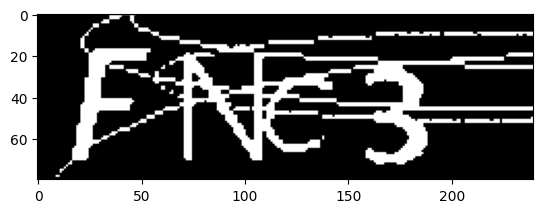

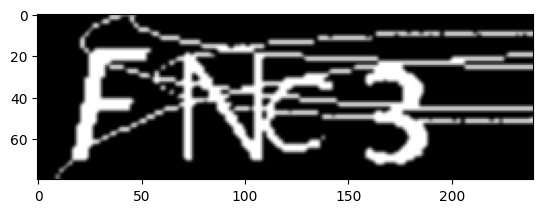

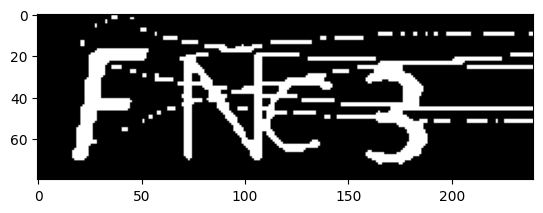

In [31]:
import matplotlib.pyplot as plt
import cv2
import numpy as np


im = cv2.imread("captcha.png")
plt.imshow(im[:,:,[2,1,0]])


# 將圖片轉成灰度圖
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#  顯示圖片

# 將圖片做二值化處理，閾值設定為127，將像素值大於127的置為0，小於127的置為255
ret, im_inv = cv2.threshold(im_gray,127,255,cv2.THRESH_BINARY_INV)
# 顯示圖片
plt.imshow(im_inv,cmap="gray")
plt.show()
# 構建卷積核的數據集，實現模糊成像的效果
kernel = 1/16*np.array([[1,2,1], [2,4,2], [1,2,1]])
# 使用高斯模糊對圖片進行降噪
im_blur = cv2.filter2D(im_inv,-1,kernel)
# 顯示圖片
plt.imshow(im_blur,cmap="gray")
plt.show()
# 將圖片做二值化處理，閾值設定為185，將像素值大於185的置為0，小於185的置為255
ret, im_res = cv2.threshold(im_blur,185,255,cv2.THRESH_BINARY)
# 显示图片
plt.imshow(im_res,cmap="gray")
plt.savefig('del_mix_pt.png')
plt.show()






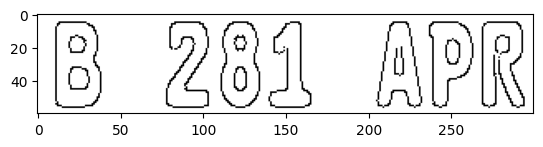

In [32]:
from imutils import paths
import numpy as np
import imutils
import cv2
import pickle
from keras.models import load_model
from imutils import paths
from helper import resize_to_fit
import numpy as np
import matplotlib.pyplot as plt

model_name = 'captcha_model.hdf5'
model_labels = 'model_labels.dat'

#Loads the model from the disk
model = load_model(model_name)

#load the transformer with the tags
with open(model_labels, 'rb') as f:
    lb = pickle.load(f)

    #Loads the image from the disk
image = cv2.imread('del_mix_pt.png')

#changes the aspect ratio of the image
resized = imutils.resize(image.copy(), width=300)

#puts the image in grayscale for latter use in the model
gray = cv2.cvtColor(resized.copy(), cv2.COLOR_BGR2GRAY)

#applies a blur to make the image
blurred = cv2.GaussianBlur(resized, (9, 9), 0)

#gets the edges of the image
edges = cv2.Canny(blurred, 75, 200)
plt.imshow(edges, cmap=plt.cm.binary)

#looks for contours
cnts = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
output = resized.copy()

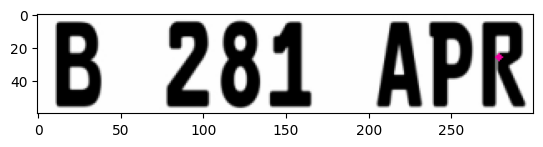

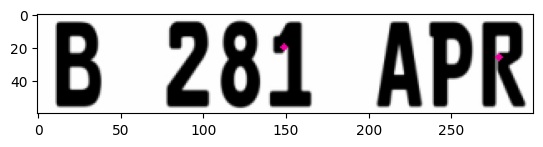

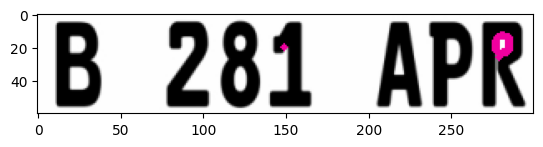

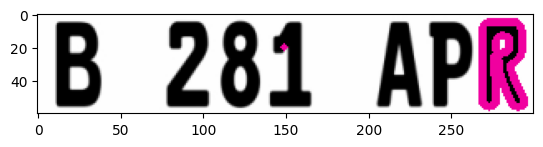

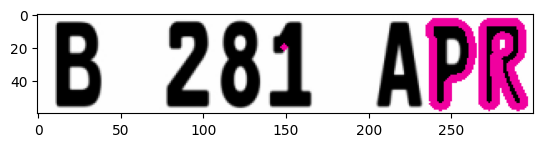

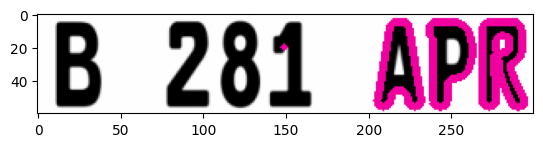

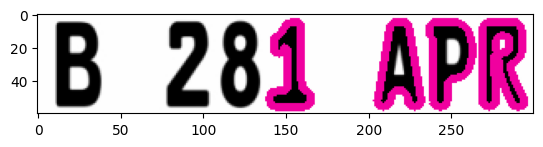

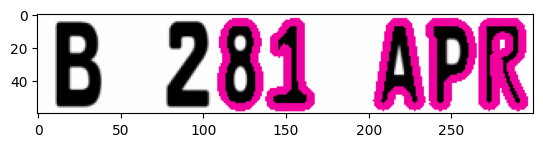

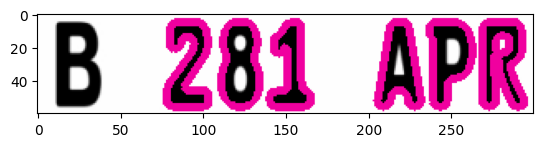

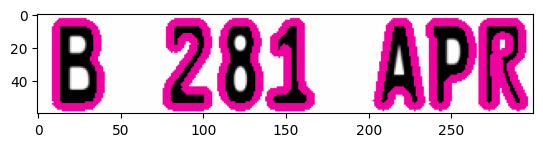

In [33]:
letter_image_regions = []

for cnt in cnts:
    cv2.drawContours(output, [cnt], -1, (240, 0, 159),3)
    (x, y, w, h) = cv2.boundingRect(cnt)
    #Verifies that a contour is not to big
    if w / h > 1.5:
        # This contour is too wide to be a single letter!
        # Split it in half into two letter regions!
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
    else:
        # This is a normal letter by itself
        letter_image_regions.append((x, y, w, h))
    plt.imshow(output,cmap =plt.cm.binary)
    plt.show()
#puts the contours in order
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

In [34]:
#eliminitates a contour if its to small
for coordenates in letter_image_regions:
    if coordenates[2]<20 or coordenates[3]<25:
        letter_image_regions.remove(coordenates)

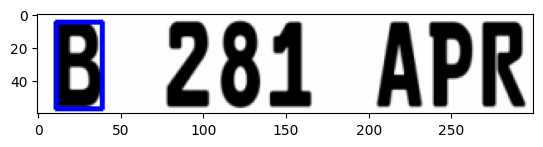

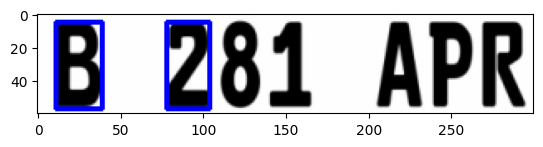

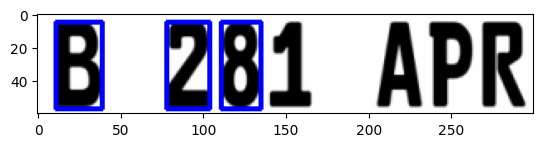

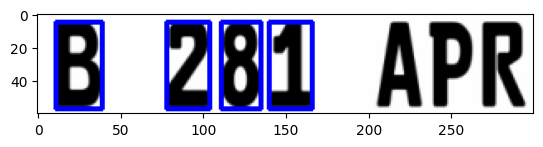

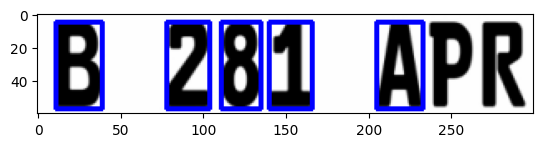

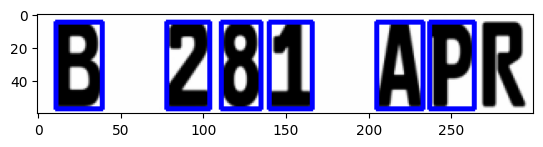

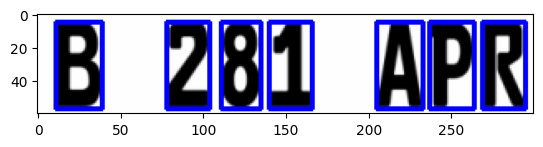

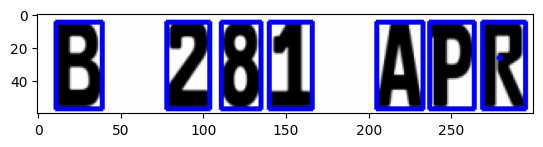

In [35]:
for region in letter_image_regions:
    start_point = (region[0], region[1])
    final_point = (region[0]+region[2], region[1]+region[3])
    cv2.rectangle(resized, start_point, final_point, (0,0,255), 2)
    plt.imshow(resized, cmap=plt.cm.binary)
    plt.show()

1/1 [==============================] - 0s 110ms/step


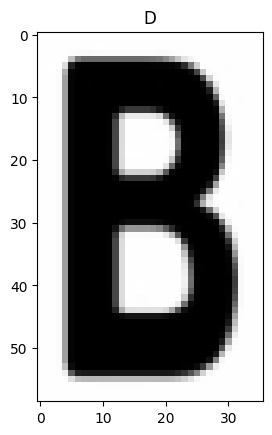

1/1 [==============================] - 0s 19ms/step


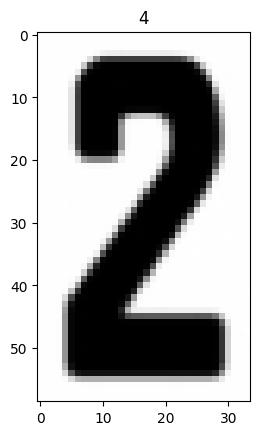

1/1 [==============================] - 0s 18ms/step


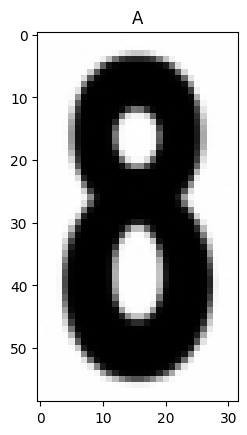

1/1 [==============================] - 0s 21ms/step


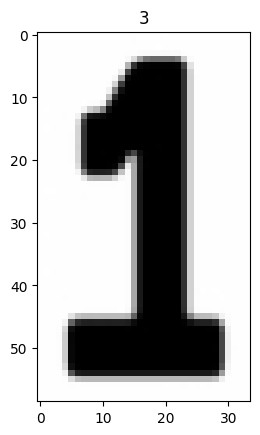

1/1 [==============================] - 0s 19ms/step


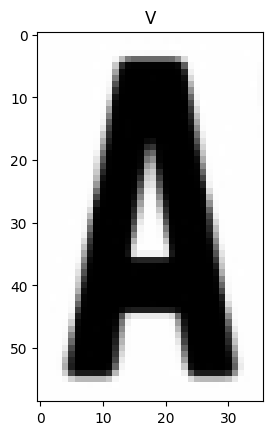

1/1 [==============================] - 0s 19ms/step


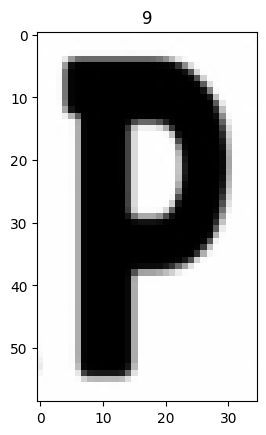

1/1 [==============================] - 0s 21ms/step


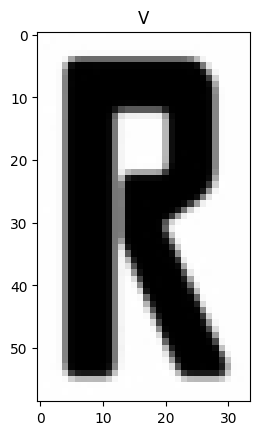

1/1 [==============================] - 0s 20ms/step


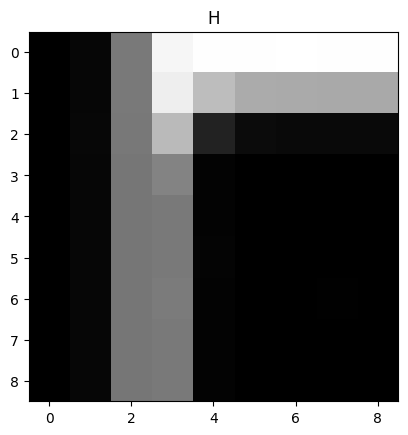

The captcha text is: D4A3V9VH


In [36]:
# this list will save the predictions
predictions = []

for letter in letter_image_regions:
    x, y, w, h = letter
    #extracts the letter of the image with a 4 pixel margin

    letter = gray[y - 4:y + h + 4, x - 4:x + w + 4]
    plt.imshow(letter, cmap='gray')
    #rescales the image to make it 20x20, the size the model takes in
    letter = resize_to_fit(letter, 20,20)
    #turns the image into a 4d tensor
    letter = np.expand_dims(letter, axis=2)
    letter = np.expand_dims(letter, axis=0)
    #forwards the image to the neuralnet
    prediction = model.predict([letter])
    #reverts the image to a one-hot vector88
    prediction = lb.inverse_transform(prediction)[0]

    plt.title(prediction)
    plt.show()
    predictions.append(prediction)

#needs better training data...
captcha1 = "".join(predictions)
print(f"The captcha text is: {captcha1}")

captcha = WebDriverWait(driver, 10).until(
EC.presence_of_element_located((By.NAME, "validateStr"))
 )
captcha.clear()
captcha.send_keys(captcha1)

In [37]:
# import cv2 as cv
# import pytesseract
# from PIL import Image
#
# def recognize_text(image):
#     # 边缘保留滤波  去噪
#     blur =cv.pyrMeanShiftFiltering(image, sp=8, sr=60)
#     cv.imshow('dst', blur)
#     # 灰階
#     gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)
#     # 二值化
#     ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
#     print(f'二值化自動適應值：{ret}')
#     cv.imshow('binary', binary)
#     # 獲取結構且操作
#     kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 2))
#     bin1 = cv.morphologyEx(binary, cv.MORPH_OPEN, kernel)
#     cv.imshow('bin1', bin1)
#     kernel = cv.getStructuringElement(cv.MORPH_OPEN, (2, 3))
#     bin2 = cv.morphologyEx(bin1, cv.MORPH_OPEN, kernel)
#     cv.imshow('bin2', bin2)
#     # 邏輯運算 讓背景變白 字體黑 方便識別
#     cv.bitwise_not(bin2, bin2)
#     cv.imshow('binary-image', bin2)
#     # 識別
#     test_message = Image.fromarray(bin2)
#     text = pytesseract.image_to_string(test_message)
#     print(f'識別結果：{text}')
#
#     captcha = WebDriverWait(driver, 10).until(
#     EC.presence_of_element_located((By.NAME, "validateStr"))
# )
#     captcha.clear()
#     captcha.send_keys(text)
#
# src = cv.imread('del_mix_pt.png')
# cv.imshow('input image', src)
# recognize_text(src)
# # cv.waitKey(0)
# # cv.destroyAllWindows()
#
#


In [38]:
username = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.NAME, "uid"))
)
password = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.NAME, "birthday"))
)

login = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.ID, "search1"))
)




username.clear()
password.clear()

username.send_keys('你的身分證')
password.send_keys('你的生日')

time.sleep(5)
login.send_keys(Keys.RETURN)


In [39]:
#driver.quit()